Set up the functions and variables:

In [16]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [17]:
import requests
url = (
    "https://elifesciences.org/download/"
    "aHR0cHM6Ly9jZG4uZWxpZmVzY2llbmNlcy5"
    "vcmcvYXJ0aWNsZXMvNDI1MDgvZWxpZmUtND"
    "I1MDgtZmlnMi1kYXRhMS12Mi54bHN4/"
    "elife-42508-fig2-data1-v2.xlsx"
    "?_hash=Hh3ocah43An8im3VeACcZ%2F"
    "TxN1OLx58raFS1Bj%2Brtrw%3D"
)
filename = "zavrel/elife-42508-fig2-data1-v2.xlsx"
data = requests.get(url)
with open(filename, 'wb') as file:
    file.write(data.content)

In [18]:
from imports import *

In [19]:

zavrel = DataImporter()
blue_light = 27.5

HU = Colors()

Set up the plots:

In [20]:
sns.set_style('ticks')  # darkgrid, white grid, dark, white and ticks
# sns.set(rc={'axes.facecolor': HU.oldgreygreen + [.5]})
plt.rc('axes', titlesize=19)     # fontsize of the axes title
plt.rc('axes', labelsize=17)     # fontsize of the x and y labels
plt.rc('xtick', labelsize=14)    # fontsize of the tick labels
plt.rc('ytick', labelsize=14)    # fontsize of the tick labels
plt.rc('legend', fontsize=13)    # legend fontsize
plt.rc('font', size=15)          # controls default text sizes
plt.rc('lines', linewidth=3)     # width of the lines

def make_Axes(x):
    x.set_xlabel("Photon flux [$\\mu mol\\cdot m^{-2} s^{-1}$]")
    x.set_ylabel("Growth rate [$h^{-1}$]")
    x.set_xlim(0, 1100*1.1)
    x.set_ylim(0)


CM = 1/2.54  # convert cm to inch

SAVEFIGS = False
SAVEPATH = "plots/"
IMG_TYPE = ".pdf"
IMG_SIZE = np.array([6*CM, 4.5*CM])*2.2

Now we set up variables we'll need for our simulation and import the model.

In [21]:
PHOTON_ID = "EX_E1_ext_b"
NITRATE_ID = "EX_C00244_ext_b"
O2_ID = "EX_C00007_ext_b"
CO2_ID = "EX_C00011_ext_b"
EPS2 = "PR0044"
EPS1 = "PR0030"
NDH = ["PR000" + i for i in ["4", "6"]]  # , "7", "5"]]
gly = (True, 2)

LIGHTIN = zavrel.get("light")
GROWTHRATE = zavrel.get("growth")
O2 = zavrel.value("net O2 fba")
CO2 = zavrel.value("CO2 fba")
RESP = zavrel.value("dark resp fba")
GLYCOGEN = zavrel.get("glycogen")/zavrel.value("DW")
PROTEIN = zavrel.get("protein")/zavrel.value("DW")

N_DATA = 100

new_syn = split_rubisco(import_model(
        '../../models_sbml/Synechocystis6803_SBML_COBRA_24_4_17.sbml'
    ), 300/97)
# knock out cell wall atpase, to prevent "atp from nothing" production:
new_syn.reactions.PR0045.knock_out()

new_syn = update_glycogen(new_syn, 3.41)

photons = np.linspace(0, LIGHTIN[-1]*1.1, N_DATA) + blue_light


glyc_fitted = fit_glyc(
    zavrel.get("light") + blue_light,
    zavrel.get("glycogen")/zavrel.get("DW")
)

Scaling...
 A: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00
Problem data seem to be well scaled


No objective coefficients in model. Unclear what should be optimized


Now we calculate the absorbed light with integration over the depth of the reactor  with lambert-beer.
Light at  depth z is I<sub>z</sub> = I<sub>0</sub> e<sup>-&epsilon; &rho;<sub>v</sub> z</sup>.
When integrated over the reactors depth we get J<sub>I</sub><sup>exp</sup> = $\frac{I_{abs}}{\rho_{A}}$ .
Blue photons are expected to be absorbed at the same rate:

In [22]:
def calc_light(blue: float) -> np.array:
    light_calc = (
        (
            zavrel.get("light cap with error")
            +
            (
                blue_light * zavrel.get("light cap with error")
                /
                zavrel.get("light with error") * blue
            )
        )
        /
        (zavrel.get("DW with error") * 0.02) * (60*60) / 1000
    )
    return light_calc


light_calc_with_error_b0 = calc_light(0)
light_calc_with_error_b100 = calc_light(1)
light_calc_with_error = calc_light(.66)

Let's start
We will first fit all our parameters to the data. This is: p<sub>max</sub>, &alpha;, &alpha;<sub>b</sub>, photodamage, respiration coefficient and nGAM

In [23]:
with new_syn:
    (pmax, alpha, alpha2, kd, mehl, maint), pcov = op.curve_fit(
        pd_fitting_w_resp(new_syn, PHOTON_ID, gly),
        np.hstack((LIGHTIN, np.delete(LIGHTIN, [5, 7])))+blue_light,
        np.hstack((GROWTHRATE*1000, np.delete(RESP, [5, 7]))),
        p0=(110, .5/3.6, .66, 6, 5, 1.3),
        bounds=((100, 0, 0, 0.01, 0, 0), (125, 1, 1, 100, 50, 20))
    )

Then add the value for respiration to the model:

In [24]:
resp_rxns = [
    new_syn.reactions.get_by_id(X) for X in [
        "PR0010", "PR0010_2", "PR0011", "PR0011_2"
    ]
]
use_sum = sum([x.flux_expression for x in resp_rxns])
some_flux = new_syn.problem.Constraint(
    use_sum - mehl/100 * new_syn.reactions.PR0043.flux_expression,
    lb=0,
    ub=1000,
    name="respiration"
)
new_syn.add_cons_vars([some_flux])

With &alpha; we fitted a factor to convert irradiated photons per area to absobed photons per CDW. We can compare this linear fit with the absorbed photons that we calculated earlier. For demsonstrating purposes, let's add the blue photons with an efficiency of 0-100%:

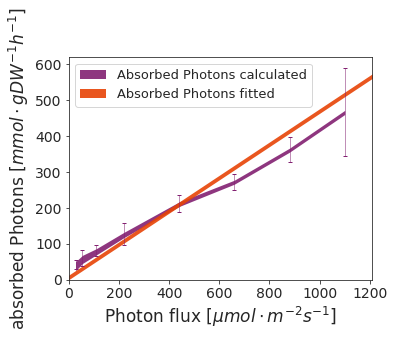

In [25]:
show_points = False

fig, ax = plt.subplots(figsize=IMG_SIZE)
ax.fill_between(
    LIGHTIN,
    [p.n for p in light_calc_with_error_b0],
    [p.n for p in light_calc_with_error_b100],
    facecolor=HU.violet+[0.9], linewidth=0,
    label="Absorbed Photons calculated"
)
ax.fill_between(
    photons-blue_light,
    alpha*3.6*(photons-blue_light), alpha*3.6*(photons),
    facecolor=HU.orange+[0.9], linewidth=0,
    label="Absorbed Photons fitted"
)
ax.errorbar(
    LIGHTIN, [p.n for p in light_calc_with_error],
    [p.s for p in light_calc_with_error],
    fmt="none", elinewidth=.5, capsize=2, ecolor=HU.violet
)
if show_points:
    ax.plot(
        LIGHTIN, p_calc := [p.n for p in light_calc_with_error],
        "o", color=HU.violet,
        label="Absorbed Photons calculated"
    )
    ax.plot(
        LIGHTIN,
        alpha*3.6*(LIGHTIN+alpha2*blue_light), "o",
        color=HU.orange,
        label="Absorbed Photons fitted"
    )
make_Axes(ax)
ax.legend()
ax.set_ylabel("absorbed Photons [$mmol\\cdot gDW^{-1} h^{-1}$]")
# ax.set_xlabel("Photons irradiated [$µE\\cdot m^{-2} s^{-1}$]")

plt.tight_layout(pad=0.3)
fig.show()
if SAVEFIGS:
    fig.savefig(SAVEPATH+"photons"+IMG_TYPE, bbox_inches='tight')

For more accurate predictions the biomass is updated prior to each simulation to represent the measured values for glycogen and protein content in the cell.
The Biomass composition changes accordingly:

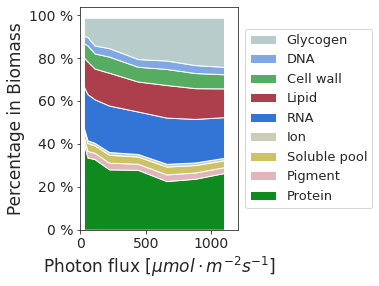

In [26]:
stackes = {}
with new_syn:
    for ind in range(len(LIGHTIN)):
        new_syn = update_prot_glyc(
            new_syn, PROTEIN[ind]*100, GLYCOGEN[ind]*100
        )
        bof = new_syn.reactions.BM0009
        stackes[LIGHTIN[ind]] = {
            "BM_comp": [
                met.name.replace(" component of biomass_cyt", "")
                for met in bof.reactants
                if met.id not in [
                    "C00002_cyt", "C00001_cyt"
                ]
            ],
            "percent": [
                bof.get_coefficient(met) * -100
                for met in bof.reactants
                if met.id not in [
                    "C00002_cyt", "C00001_cyt"
                ]
            ],
            "colors": [
                HU.oldgreen,
                HU.oldred + [.3],
                HU.oldsand,
                HU.oldgreygreen,
                HU.oldblue + [.8],
                HU.oldred + [.8],
                HU.oldgreen + [.7],
                HU.oldblue + [.5],
                HU.oldgreyblue
            ]
        }

fig, ax = plt.subplots(figsize=IMG_SIZE)
ax.stackplot(
    LIGHTIN,
    [stackes[i]["percent"][0] for i in LIGHTIN],
    [stackes[i]["percent"][1] for i in LIGHTIN],
    [stackes[i]["percent"][2] for i in LIGHTIN],
    [stackes[i]["percent"][3] for i in LIGHTIN],
    [stackes[i]["percent"][4] for i in LIGHTIN],
    [stackes[i]["percent"][5] for i in LIGHTIN],
    [stackes[i]["percent"][6] for i in LIGHTIN],
    [stackes[i]["percent"][7] for i in LIGHTIN],
    [stackes[i]["percent"][8] for i in LIGHTIN],
    labels=stackes[LIGHTIN[0]]["BM_comp"],
    colors=stackes[LIGHTIN[0]]["colors"]
)
make_Axes(ax)
ax.set_yticks([0, 20, 40, 60, 80, 100])
ax.set_yticklabels(["0 %", "20 %", "40 %", "60 %", "80 %", "100 %"])
ax.set_ylabel("Percentage in Biomass")
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[::-1], labels[::-1], loc="center left", bbox_to_anchor=(1, .5))

plt.tight_layout(pad=0.3)
fig.show()
if SAVEFIGS:
    fig.savefig(SAVEPATH+"BM_stacked"+IMG_TYPE)

Now we'll start simulating. These can take quite some time. If you want faster results, lower the N_DATA value ta have less data points (and less smooth plots)
Let's start with stoichometric gwoth:

In [27]:
# N_DATA = 1000
# photons = np.linspace(0, LIGHTIN[-1]*1.1, N_DATA) + blue_light

with mp.Pool(mp.cpu_count()-2) as pool:
    with new_syn:
        stoich_gro = np.array(pool.starmap(
                photodamage_helper,
                (
                    (
                        new_syn,
                        PHOTON_ID,
                        "BM0009",
                        p*-1,
                        10**100,
                        0,
                        alpha, alpha2, 0,
                        gly, maint
                    )
                    for p in photons
                )
            ))

And plot it:


MAX stoich yield:  1.82286185793858


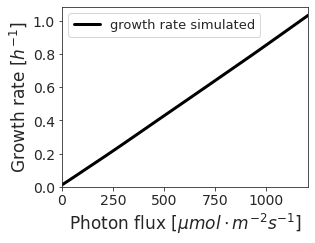

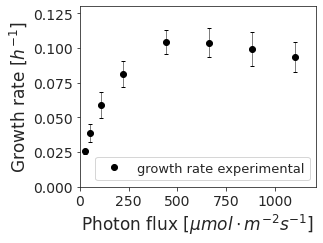

In [28]:
fig, ax = plt.subplots(figsize=IMG_SIZE*.85)
ax.plot(
    photons-blue_light, stoich_gro, 'k-', label="growth rate simulated"
)
make_Axes(ax)
ax.legend()
fig.show()
if SAVEFIGS:
    fig.savefig(SAVEPATH + "growth"+IMG_TYPE)
fig1, ax1 = plt.subplots(figsize=IMG_SIZE*.85)
ax1.plot(LIGHTIN, GROWTHRATE, "ko", label="growth rate experimental")
ax1.errorbar(
    LIGHTIN, GROWTHRATE, zavrel.error("growth"),
    fmt="none", elinewidth=.5, capsize=2, ecolor="k"
)
make_Axes(ax1)
ax1.set_ylim(0, 0.13)
ax1.legend(loc="lower right")

plt.tight_layout(pad=0.3)
fig1.show()
if SAVEFIGS:
    fig1.savefig(SAVEPATH + "growth_exp"+IMG_TYPE)

print(
    "MAX stoich yield: ",
    max(np.array(stoich_gro)/plus_blue(photons, alpha, alpha2)*1000)
)

In [29]:

with new_syn:
    (pmax_nd, alpha_nd, alpha2_nd, kd_nd), _ = op.curve_fit(
        pd_fitting(new_syn, PHOTON_ID, gly, maint),
        LIGHTIN[:5]+blue_light, GROWTHRATE[:5],
        p0=(100, 0.6/3.6, 0.6, 0),
        bounds=((20, 0.2/3.6, 0, 0), (300, 1, 1, 0.0000001))
    )

with mp.Pool(mp.cpu_count()-2) as pool:
    gro_nd = pool.starmap(
            photodamage_helper,
            (
                (
                    new_syn,
                    PHOTON_ID,
                    "BM0009",
                    p*-1,
                    get_kl(new_syn, pmax_nd),
                    kd_nd,
                    alpha_nd,
                    alpha2_nd, 0,
                    gly, maint
                )
                for p in photons
            )
        )


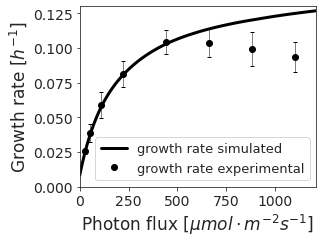

In [30]:

fig, ax = plt.subplots(figsize=IMG_SIZE*.85)
ax.plot(photons-blue_light, gro_nd, "k", label="growth rate simulated")
ax.plot(LIGHTIN, GROWTHRATE, "ko", label="growth rate experimental")
ax.errorbar(
    LIGHTIN, GROWTHRATE, zavrel.error("growth"),
    fmt="none", elinewidth=.5, capsize=2, ecolor="k"
)
make_Axes(ax)
ax.legend()
ax.set_ylim(0, 0.13)

plt.tight_layout(pad=0.3)
fig.show()
if SAVEFIGS:
    fig.savefig(SAVEPATH + "growth_monod"+IMG_TYPE)

Now simulate with all paramters and grep the values for growthrate, O<sub>2</sub>, CO<sub>2</sub> and NO<sub>3</sub>


In [31]:
with mp.Pool(mp.cpu_count()-2) as pool:
    groo2co2 = pool.starmap(
        photodamage_helper,
        (
            (
                new_syn,
                PHOTON_ID,
                ["BM0009", O2_ID, CO2_ID, NITRATE_ID],
                p*-1,
                get_kl(new_syn, pmax),
                kd,
                alpha,
                alpha2, 0,
                gly, maint
            )
            for p in photons
        )
    )
    gro = np.array([f[0] for f in groo2co2])
    o2 = np.array([f[1] for f in groo2co2])
    co2 = np.array([f[2] for f in groo2co2])
    no3 = np.array([f[3] for f in groo2co2])

Plot growth rate:

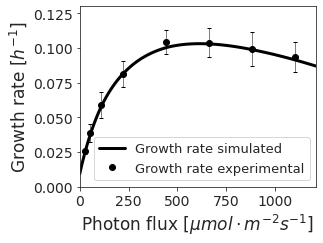

In [32]:
fig, ax = plt.subplots(figsize=IMG_SIZE*.85)

p1 = ax.plot(photons-blue_light, gro, "k", label="Growth rate simulated")
p2 = ax.plot(LIGHTIN, GROWTHRATE, "ko", label="Growth rate experimental")
ax.errorbar(
    LIGHTIN, GROWTHRATE, zavrel.error("growth"),
    fmt="none", elinewidth=.5, capsize=2, ecolor="k"
)
make_Axes(ax)
ax.legend()
ax.set_ylim(0, 0.13)

plt.tight_layout(pad=0.3)
fig.show()
if SAVEFIGS:
    fig.savefig(SAVEPATH + "growth_monod_pd"+IMG_TYPE)

Plot O<sub>2</sub>

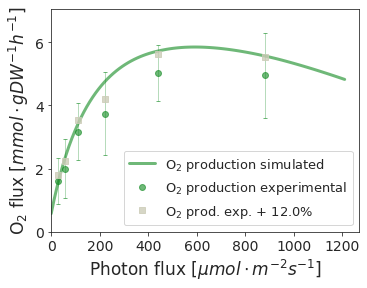

In [33]:
fig, ax = plt.subplots(figsize=IMG_SIZE)  # figsize=(17.32*CM, 13*CM))
p3 = ax.plot(
    photons-blue_light, o2, color=HU.oldgreen + [.6],
    label="O$_2$ production simulated"
)
p4 = ax.plot(
    LIGHTIN, O2, "o", color=HU.oldgreen + [.6],
    label="O$_2$ production experimental"
)
ax.errorbar(
    LIGHTIN, O2, zavrel.error("O2 fba"),
    fmt="none", elinewidth=.5, capsize=2, ecolor=HU.oldgreen + [.6]
)
O2_CORRECTION = 1.12
p5 = ax.plot(
    LIGHTIN, O2 * O2_CORRECTION, "s", color=HU.oldgreygreen + [.8],
    label=f"O$_2$ prod. exp. + {round((O2_CORRECTION-1)*100, 0)}%"
)
O2_CORRECTION = 1
p = p3 + p4 + p5
labels = [lab.get_label() for lab in p]
ax.legend(p, labels)
ax.set_ylim(0, 7.05)
ax.set_xlim(0)
ax.set_xlabel("Photon flux [$\\mu mol\\cdot m^{-2} s^{-1}$]")
ax.set_ylabel(r"O$_2$ flux [$mmol\cdot gDW^{-1}h^{-1}$]")

plt.tight_layout(pad=0.3)
fig.show()
if SAVEFIGS:
    fig.savefig(SAVEPATH + "growth_plus_o2"+IMG_TYPE)

We also look at the yield, i.e. the biomass production divided by the irradiated photons. For the experimental values we span a range from 0-100% usage of blue photons.

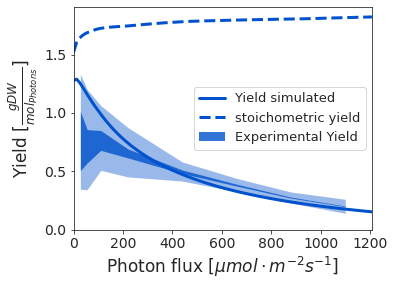

In [34]:
fig, ax = plt.subplots(figsize=IMG_SIZE)  # figsize=(17.32*CM, 13*CM))
ax.plot(
    photons-blue_light,
    gro/plus_blue(photons, alpha, alpha2)*1000,
    color=HU.oldblue, label="Yield simulated"
)
ax.plot(
    photons-blue_light,
    stoich_gro/plus_blue(photons, alpha, alpha2)*1000,
    "--", color=HU.oldblue, label="stoichometric yield"
)
make_Axes(ax)
ax.set_ylim(0)
ax.set_ylabel("Yield [$\\frac{gDW}{mol_{Photons}}$]")
ax.legend()

ax.fill_between(
    zavrel.get("light"),
    np.array([
        -y.s for y in
        zavrel.get(
            "growth with error"
        )/light_calc_with_error_b100*1000
    ]) +
    GROWTHRATE/np.array([i.n for i in light_calc_with_error_b100])*1000,
    np.array([
        y.s for y in
        zavrel.get(
            "growth with error"
        )/light_calc_with_error_b0*1000
    ]) +
    GROWTHRATE/np.array([i.n for i in light_calc_with_error_b0])*1000,
    facecolor=HU.oldblue+[0.4], linewidth=0
)
ax.fill_between(
    zavrel.get("light"),
    GROWTHRATE/np.array([i.n for i in light_calc_with_error_b0])*1000,
    GROWTHRATE/np.array([i.n for i in light_calc_with_error_b100])*1000,
    color=HU.oldblue+[0.8], linewidth=0,
    label=("Experimental Yield")
)
ax.legend()

plt.tight_layout(pad=0.3)
plt.show()
if SAVEFIGS:
    fig.savefig(SAVEPATH + "yield_int_light"+IMG_TYPE)